In [25]:
import numpy as np
import h5py

import scipy.signal as sg
import matplotlib.pyplot as plt

import IPython

In [110]:
import importlib
import soundfeatures
importlib.reload(soundfeatures)

<module 'soundfeatures' from 'C:\\Workspace\\Projects\\Toolbox\\Toolbox\\Toolbox\\soundfeatures\\soundfeatures.py'>

## Load file with sound

In [4]:
record_filename = 'words08_overt_2021.11.17_17.28.51.h5'

fs = 4096
sound_channel = 64
label_channel = 70

with h5py.File(record_filename, 'r+') as input_file:
    sound = input_file['raw_data/sound'][()].astype("float64")
    label = input_file['raw_data/labels'][()].astype("int32")

print('sound', sound.shape[0] / fs, 's')

sound 333.75048828125 s


## Look at the whole sound ans small part

In [39]:
signal_long = soundfeatures.butter_filter(sound, fs, order=4, freq=0.5, btype='highpass')
signal_short = signal_long[665345:665345+12288]

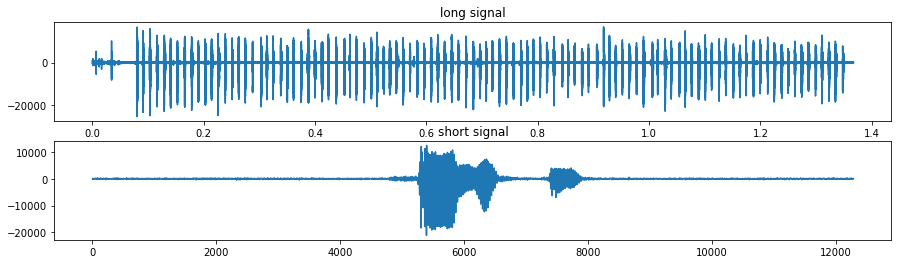

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].plot(signal_long)
ax[0].set_title('long signal')
ax[1].plot(signal_short)
ax[1].set_title('short signal')
plt.show()

## Create sound features

In [31]:
fs = 4096
frame = 128
step = 64
pad = 'center'

lpc_order = 12
lpc_window = 'hann'
# lpc_window = None

pitch_thr = 0.8

soundmask_freq = 2
soundmask_thr = 0.1

n_mel = 40
mel_fmin = 0
mel_fmax = 2048
n_mfcc = 13

In [32]:
# sf = soundfeatures.SoundFeatures(fs, frame, step, pad = 'center')

# Linear Predictive Coding

In [33]:
fs = 4096
frame = 128
step = 10
pad='center'

lpc_order = 10
lpc_window = 'hann'
# lpc_window = None

pitch_thr = 0.8

soundmask_freq = 2
soundmask_thr = 0.1

n_mel = 40
mel_fmin = 0
mel_fmax = 2048
n_mfcc = 10

## Small part

In [41]:
%%time
features_short = soundfeatures.make_sound_features(signal_short, fs, frame, step, pad=pad, 
                               lpc_order=lpc_order, lpc_window=lpc_window, 
                               pitch_thr=pitch_thr, 
                               soundmask_freq=soundmask_freq, soundmask_thr=soundmask_thr, 
                               n_mel=n_mel, mel_fmin=mel_fmin, mel_fmax=mel_fmax, n_mfcc=n_mfcc)

Wall time: 1.96 s


In [42]:
for key, value in features_short.items():
    print(key, value.shape)

sound (12406,)
soundmask (12406,)
featuremask (1228,)
pc (1228, 10)
rc (1228, 10)
lsf (1228, 10)
lar (1228, 10)
voiced (1228,)
pitch ()
lms (1228, 10)
mfcc (1228, 10)


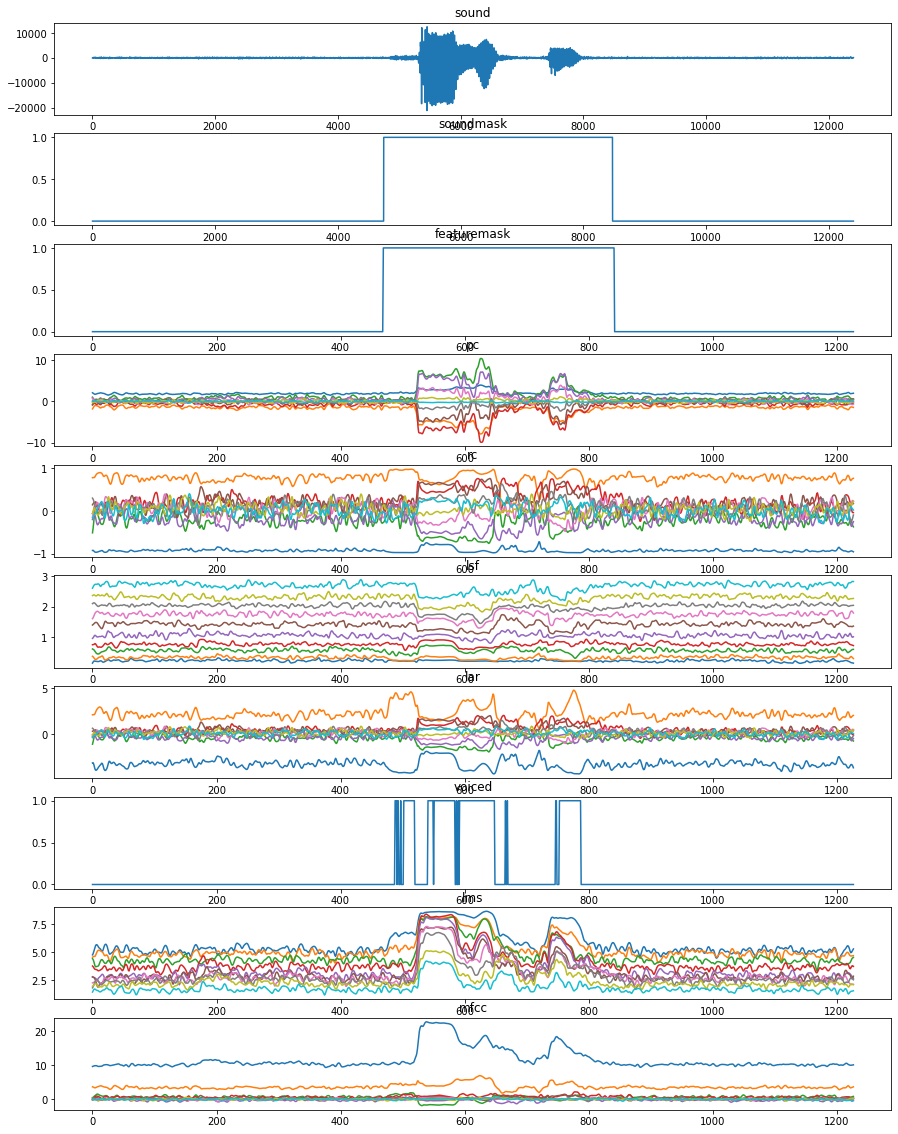

In [43]:
fig, ax = plt.subplots(len(features_short.keys()) - 1, 1, figsize=(15, (len(features_short.keys())-1)*2))

i = 0
for key in features_short.keys():
    if key == 'pitch':
        continue
    ax[i].plot(features_short[key])
    ax[i].set_title(key)
    i += 1
plt.show()

## Full soundf

In [44]:
%%time
features_long = soundfeatures.make_sound_features(signal_long, fs, frame, step, pad=pad, 
                               lpc_order=lpc_order, lpc_window=lpc_window, 
                               pitch_thr=pitch_thr, 
                               soundmask_freq=soundmask_freq, soundmask_thr=soundmask_thr, 
                               n_mel=n_mel, mel_fmin=mel_fmin, mel_fmax=mel_fmax, n_mfcc=n_mfcc)

Wall time: 3min 31s


In [47]:
for key, value in features_long.items():
    print(key, value.shape)

sound (1367160,)
soundmask (1367160,)
featuremask (136704,)
pc (136704, 10)
rc (136704, 10)
lsf (136704, 10)
lar (136704, 10)
voiced (136704,)
pitch ()
lms (136704, 10)
mfcc (136704, 10)


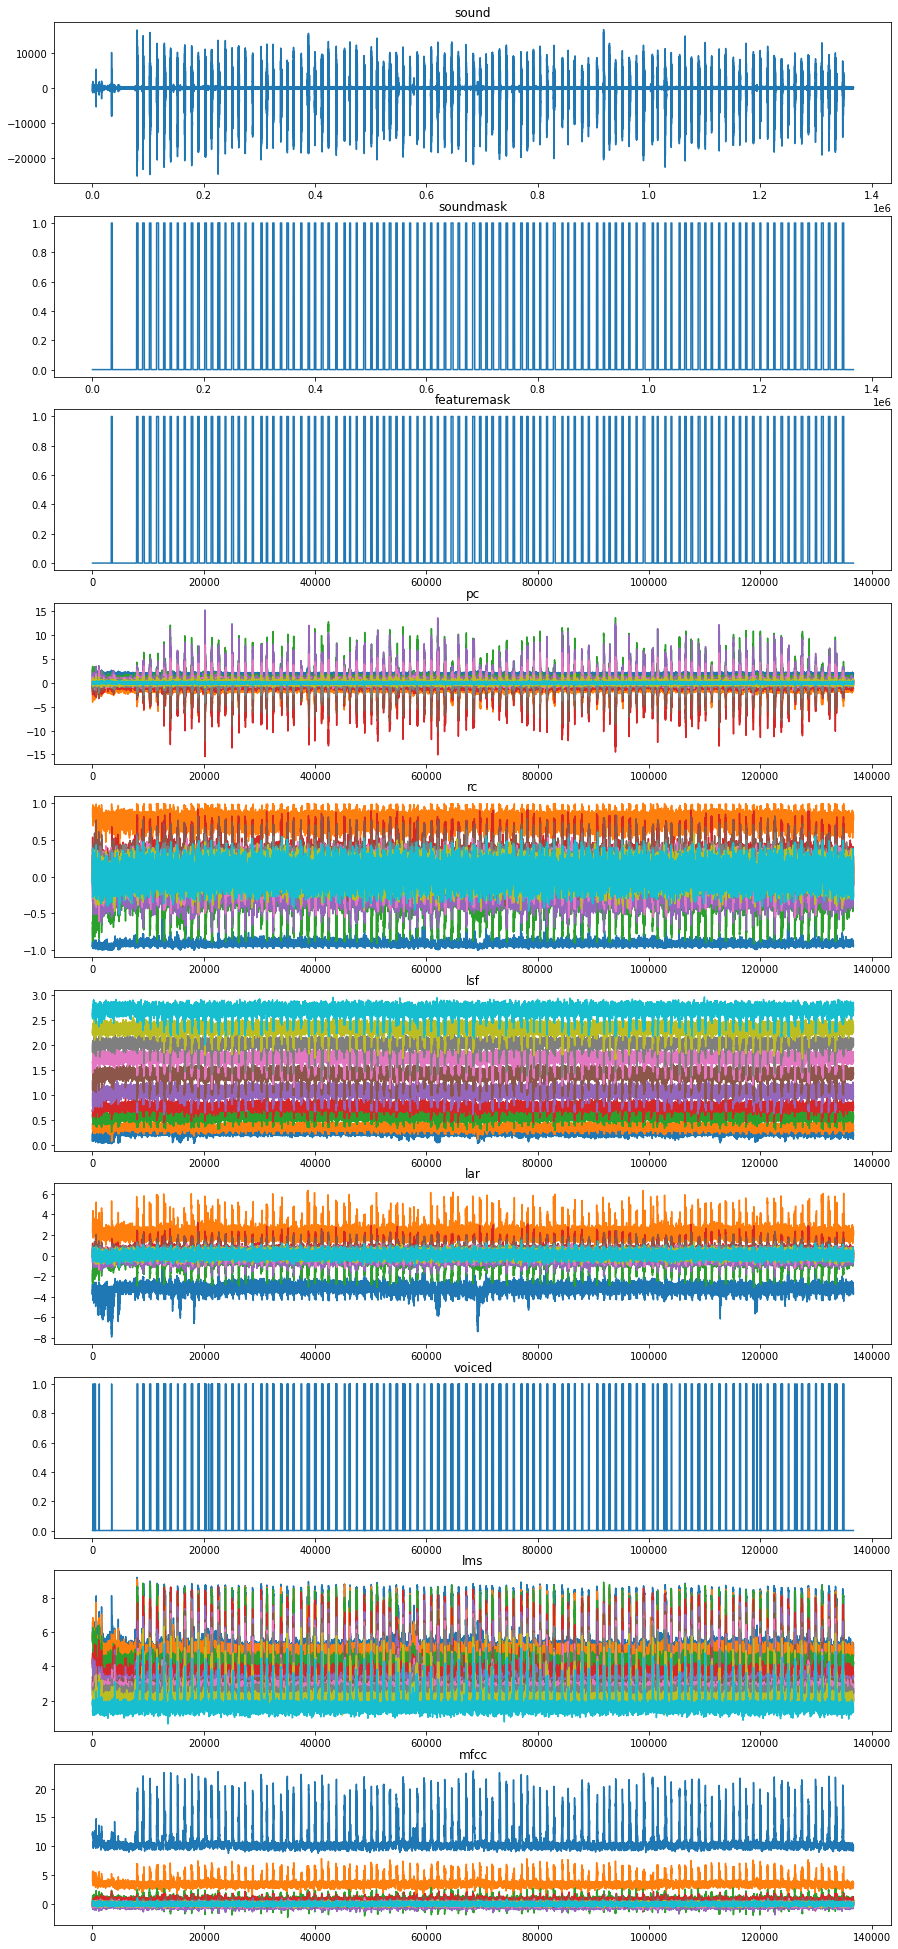

In [46]:
fig, ax = plt.subplots(len(features_long.keys()) - 1, 1, figsize=(15, (len(features_long.keys())-1)*3.5))

i = 0
for key in features_long.keys():
    if key == 'pitch':
        continue
    ax[i].plot(features_long[key])
    ax[i].set_title(key)
    i += 1
plt.show()

## Play sound with simple vocoder

In [102]:
import spectrum

pc1 = features_long['pc'][1000]
pc2 = - spectrum.lsf2poly(features_long['lsf'][1000])[1:]
pc3 = - spectrum.rc2poly(spectrum.lar2rc(features_long['lar'][1000]))[0][1:]

assert np.allclose(pc1, pc2), 'pc1 != pc2'
assert np.allclose(pc1, pc3), 'pc1 != pc3'

In [113]:
voiced = features_long['voiced']
# voiced = None
pc = features_long['pc']
pitch = features_long['pitch']
reconstructed_sound = soundfeatures.make_sound(voiced, pc, frame, step, fs, pitch, intensity=20)

(1458176,)


In [114]:
import IPython

IPython.display.Audio(reconstructed_sound, rate=4096)